In [3]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('heart_disease_statlog.csv', 'heart_disease_statlog'),
 # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Aksh@123',
    database='heart'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/chowd/OneDrive/Documents/Desktop/heart'


def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'


for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)

    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing heart_disease_statlog.csv
NaN values before replacement:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64



In [7]:
# Function to execute queries and return Pandas DataFrame
def fetch_data(query):
    with conn.cursor() as cursor:
        cursor.execute(query)
        result = cursor.fetchall()
    return pd.DataFrame(result)


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Aksh@123",
                            database = "heart")

cur = db.cursor()

In [13]:
pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


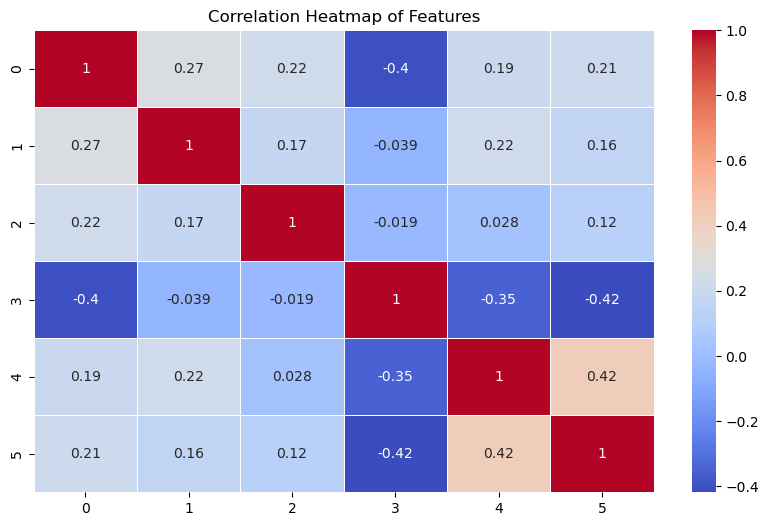

In [17]:
query = """SELECT age, trestbps, chol, thalach, oldpeak, target FROM heart_disease_statlog"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.show()

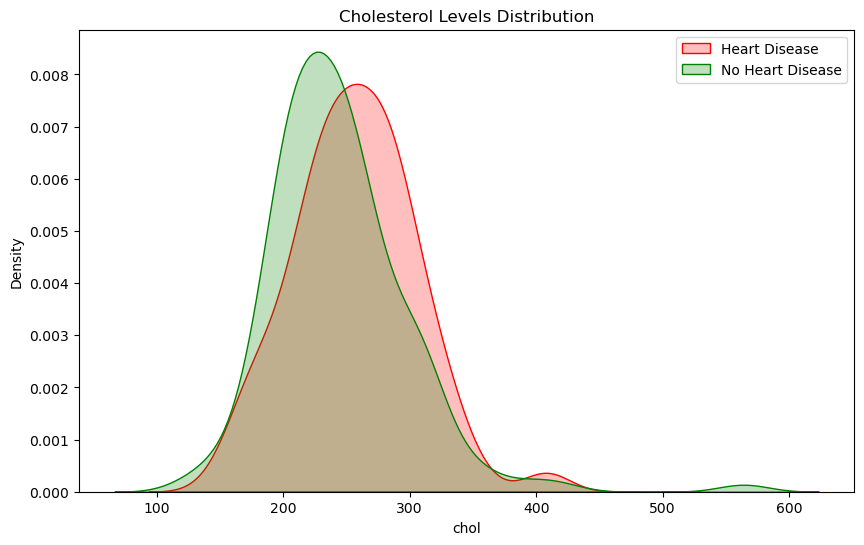

In [54]:
# Corrected visualization with the new 'fill' parameter
plt.figure(figsize=(10,6))
sns.kdeplot(df[df["target"]==1]["chol"], label="Heart Disease", fill=True, color="red")
sns.kdeplot(df[df["target"]==0]["chol"], label="No Heart Disease", fill=True, color="green")
plt.title("Cholesterol Levels Distribution")
plt.legend()
plt.show()


C:\Users\chowd\AppData\Local\Temp\ipykernel_1352\3221191721.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Age Group", loc='upper right', bbox_to_anchor=(1.2, 1))


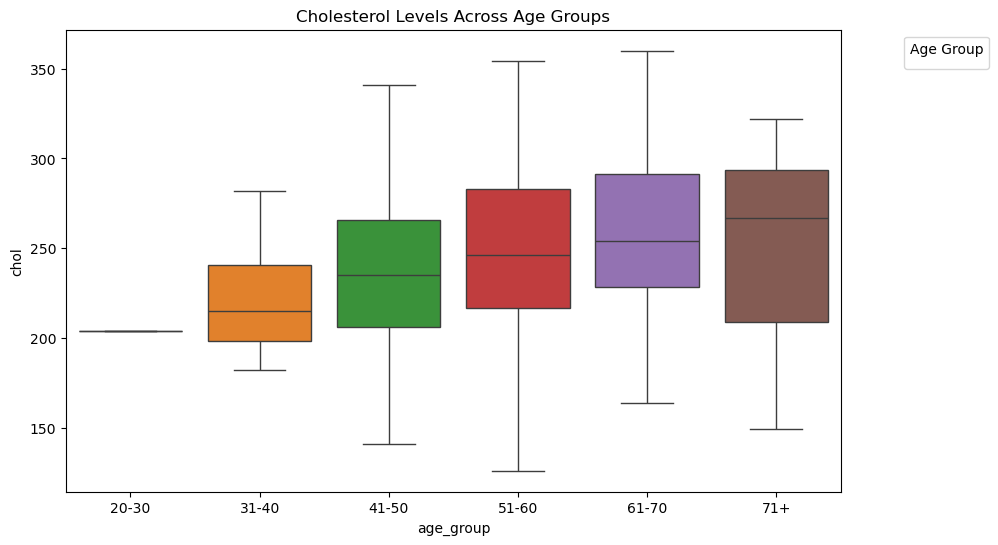

In [66]:
# Boxplot with hue parameter to avoid deprecation warning
plt.figure(figsize=(10,6))
sns.boxplot(x='age_group', y='chol', data=df, hue='age_group', showfliers=False)
plt.title("Cholesterol Levels Across Age Groups")
plt.legend(title="Age Group", loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


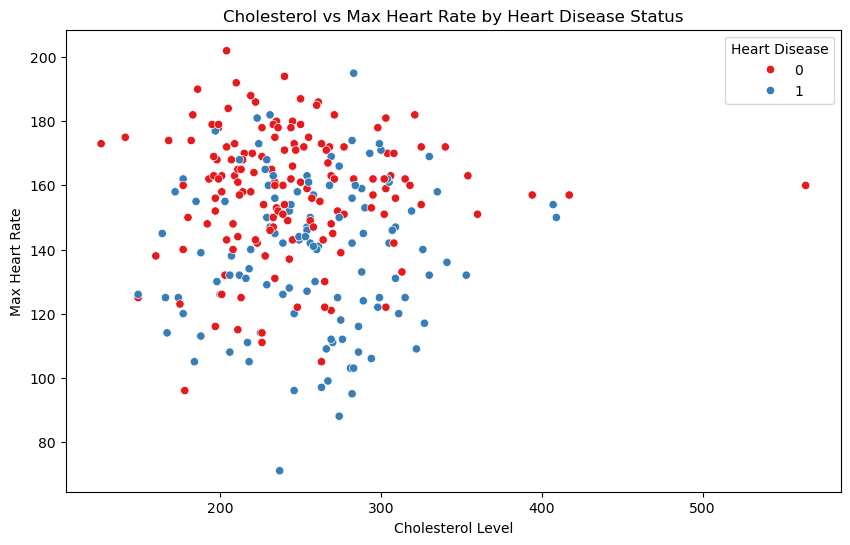

In [68]:
# Query to get cholesterol and max heart rate data grouped by target
query = """
SELECT target, chol, thalach
FROM heart_disease_statlog;
"""
cur.execute(query)
data = cur.fetchall()

# Convert to a pandas dataframe
df = pd.DataFrame(data, columns=["target", "chol", "thalach"])

# Scatter plot to visualize correlation
plt.figure(figsize=(10,6))
sns.scatterplot(x='chol', y='thalach', hue='target', data=df, palette="Set1")
plt.title("Cholesterol vs Max Heart Rate by Heart Disease Status")
plt.xlabel("Cholesterol Level")
plt.ylabel("Max Heart Rate")
plt.legend(title="Heart Disease", loc='upper right')
plt.show()


C:\Users\chowd\AppData\Local\Temp\ipykernel_1352\892618419.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y='avg_chol', data=df, palette="Set2")


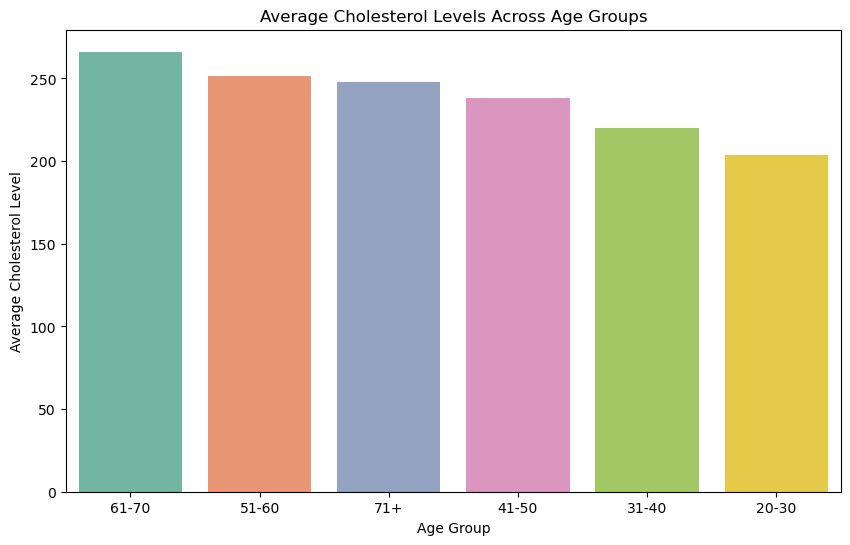

In [70]:
# Query to get average cholesterol levels for each age group
query = """
SELECT 
    CASE 
        WHEN age BETWEEN 20 AND 30 THEN '20-30'
        WHEN age BETWEEN 31 AND 40 THEN '31-40'
        WHEN age BETWEEN 41 AND 50 THEN '41-50'
        WHEN age BETWEEN 51 AND 60 THEN '51-60'
        WHEN age BETWEEN 61 AND 70 THEN '61-70'
        WHEN age > 70 THEN '71+'
    END AS age_group,
    AVG(chol) AS avg_chol
FROM heart_disease_statlog
GROUP BY age_group;
"""
cur.execute(query)
data = cur.fetchall()

# Convert to a pandas dataframe
df = pd.DataFrame(data, columns=["age_group", "avg_chol"])

# Bar plot to visualize average cholesterol levels by age group
plt.figure(figsize=(10,6))
sns.barplot(x='age_group', y='avg_chol', data=df, palette="Set2")
plt.title("Average Cholesterol Levels Across Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Average Cholesterol Level")
plt.show()


C:\Users\chowd\AppData\Local\Temp\ipykernel_1352\2786979025.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y='heart_disease_count', data=df, palette="Set1")


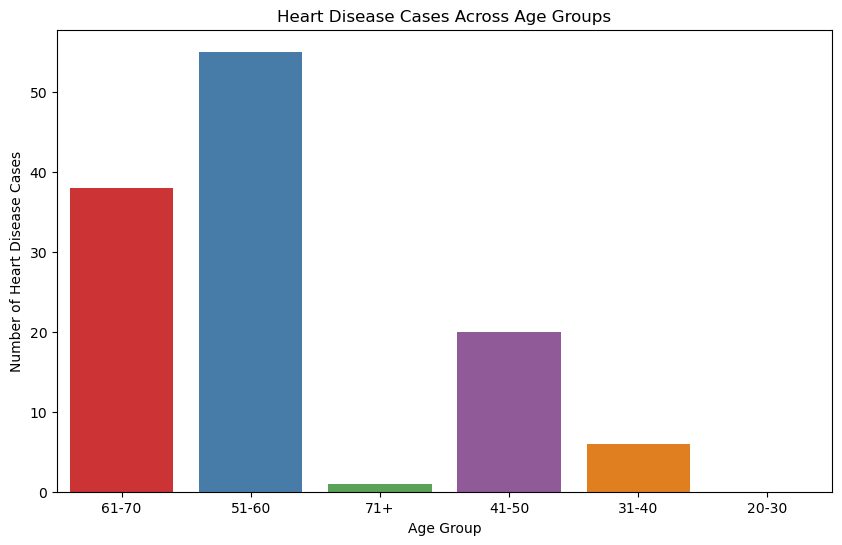

In [72]:
# Query to get count of heart disease cases for each age group
query = """
SELECT 
    CASE 
        WHEN age BETWEEN 20 AND 30 THEN '20-30'
        WHEN age BETWEEN 31 AND 40 THEN '31-40'
        WHEN age BETWEEN 41 AND 50 THEN '41-50'
        WHEN age BETWEEN 51 AND 60 THEN '51-60'
        WHEN age BETWEEN 61 AND 70 THEN '61-70'
        WHEN age > 70 THEN '71+'
    END AS age_group,
    SUM(CASE WHEN target = 1 THEN 1 ELSE 0 END) AS heart_disease_count
FROM heart_disease_statlog
GROUP BY age_group;
"""
cur.execute(query)
data = cur.fetchall()

# Convert to a pandas dataframe
df = pd.DataFrame(data, columns=["age_group", "heart_disease_count"])

# Bar plot to visualize heart disease count by age group
plt.figure(figsize=(10,6))
sns.barplot(x='age_group', y='heart_disease_count', data=df, palette="Set1")
plt.title("Heart Disease Cases Across Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Number of Heart Disease Cases")
plt.show()


C:\Users\chowd\AppData\Local\Temp\ipykernel_1352\374961429.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='target', y='avg_blood_pressure', data=df, palette="Set2")


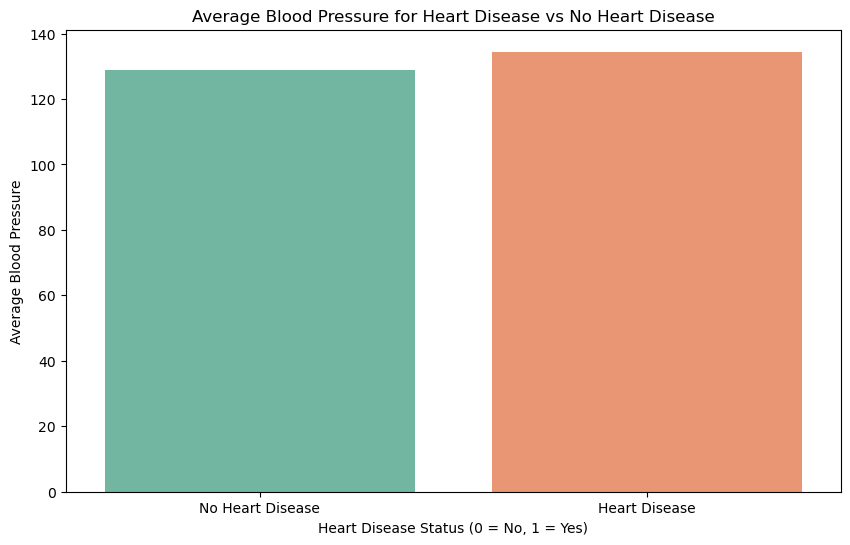

In [74]:
# Query to get average blood pressure for each target group (heart disease status)
query = """
SELECT target, AVG(trestbps) AS avg_blood_pressure
FROM heart_disease_statlog
GROUP BY target;
"""
cur.execute(query)
data = cur.fetchall()

# Convert to a pandas dataframe
df = pd.DataFrame(data, columns=["target", "avg_blood_pressure"])

# Bar plot to visualize average blood pressure by heart disease status
plt.figure(figsize=(10,6))
sns.barplot(x='target', y='avg_blood_pressure', data=df, palette="Set2")
plt.title("Average Blood Pressure for Heart Disease vs No Heart Disease")
plt.xlabel("Heart Disease Status (0 = No, 1 = Yes)")
plt.ylabel("Average Blood Pressure")
plt.xticks(ticks=[0, 1], labels=["No Heart Disease", "Heart Disease"])
plt.show()


C:\Users\chowd\AppData\Local\Temp\ipykernel_1352\4133870619.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y='avg_blood_pressure', data=df, palette="Set2")


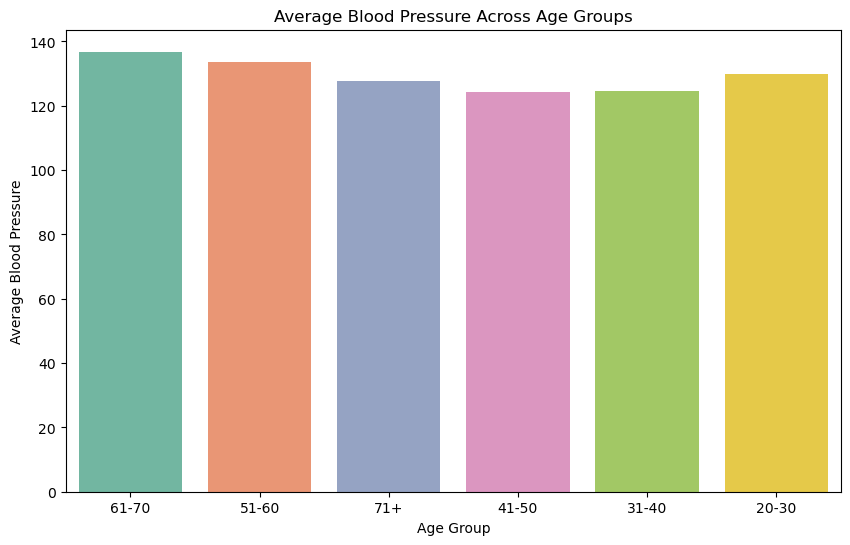

In [76]:
# Query to get average blood pressure by age group
query = """
SELECT 
    CASE 
        WHEN age BETWEEN 20 AND 30 THEN '20-30'
        WHEN age BETWEEN 31 AND 40 THEN '31-40'
        WHEN age BETWEEN 41 AND 50 THEN '41-50'
        WHEN age BETWEEN 51 AND 60 THEN '51-60'
        WHEN age BETWEEN 61 AND 70 THEN '61-70'
        WHEN age > 70 THEN '71+'
    END AS age_group,
    AVG(trestbps) AS avg_blood_pressure
FROM heart_disease_statlog
GROUP BY age_group;
"""
cur.execute(query)
data = cur.fetchall()

# Convert to a pandas dataframe
df = pd.DataFrame(data, columns=["age_group", "avg_blood_pressure"])

# Bar plot to visualize average blood pressure by age group
plt.figure(figsize=(10,6))
sns.barplot(x='age_group', y='avg_blood_pressure', data=df, palette="Set2")
plt.title("Average Blood Pressure Across Age Groups")
plt.xlabel("Age Group")
plt.ylabel("Average Blood Pressure")
plt.show()


In [80]:
# Query to fetch cholesterol and blood pressure data
query = "SELECT chol, trestbps FROM heart_disease_statlog"
cur.execute(query)
data = cur.fetchall()

# Convert to pandas dataframe
df = pd.DataFrame(data, columns=["chol", "trestbps"])

# Calculate correlation coefficient
correlation = df["chol"].corr(df["trestbps"])
print(f"Correlation between Cholesterol and Blood Pressure: {correlation}")


Correlation between Cholesterol and Blood Pressure: 0.17301917553469254
